Testing biological calibration of the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
strait_of_georgia = [54,64,68,79,62,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [20,21,23,26]
fraser_river_plume = [75,80,81]

## Phytoplankton

In [3]:
filename = "v6718_365_20241105_fisheriesOFF"
# One year of daily output, after the 15-year model burn-in. Year of output starts at 2007.

In [7]:
# Extracting SSAM diatom data
diatom_filename = "v6718_365_20241105_fisheriesOFF"
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/" + diatom_filename + "/outputSalishSea.nc"
data = xr.open_dataset(str(data_file), decode_cf=True) #[t, box, z]

ssam_time = data.t
ssam_volume = data.volume
diatoms_SSAM_tbz = data.Diatom_N * ssam_volume #convert to mg N 
diatoms_SSAM_tb = diatoms_SSAM_tbz.sum(axis=2)
diatoms_SSAM_t = diatoms_SSAM_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

In [8]:
# SalishSeaCast daily averaged diatom data for 30 days in 2007
ssc_data = xr.open_dataset('/ocean/dlatorne/Atlantis/day-avg-diatoms/SalishSeaCast_day_avg_diatoms_compressed_20070101_20070131.nc')
mesh = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')

ssc_volume = (mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth', 'y':'gridY', 'x':'gridX'})
diatoms_SSC_tzyx = ssc_data.diatoms # [t,z,y,x]
diatoms_SSC_tzyx = diatoms_SSC_tzyx * ssc_volume # convert from mmol m-3 to mmol
# Convert mmol N * 0.001 mol N * 14.0067 g/mol * 0.000001 tonnes 
diatoms_SSC_tzy = diatoms_SSC_tzyx.sum(axis=3)
diatoms_SSC_tz = diatoms_SSC_tzy.sum(axis=2)
diatoms_SSC_t = diatoms_SSC_tz.sum(axis=1) * (0.001*14.0067*0.000001) #convert to tonnes

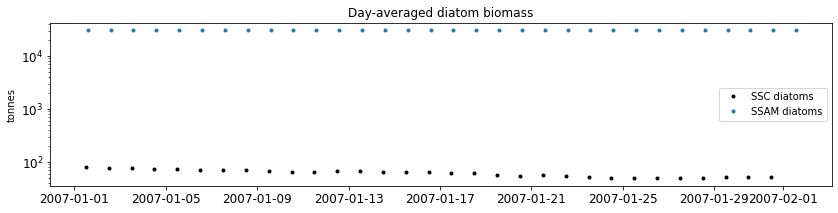

In [10]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2) #semilogy
ax.semilogy(ssam_time[5:37], diatoms_SSAM_t[5:37],'.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms'), loc='best');

In [12]:
picos_SSAM_tbz = data.PicoPhytopl_N * ssam_volume #convert to mg N 
picos_SSAM_tb = picos_SSAM_tbz.sum(axis=2)
picos_SSAM_t = picos_SSAM_tb.sum(axis=1) * 1e-9 # convert from mg N to tonnes

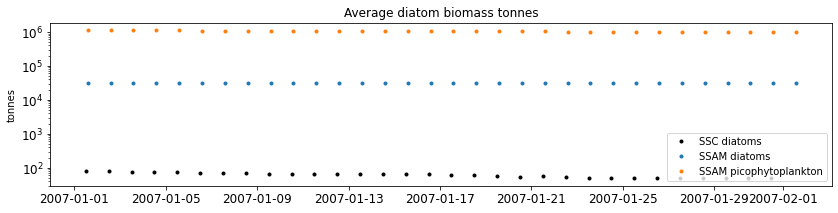

In [14]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_t, 'k.', linewidth = 2)
ax.semilogy(ssam_time[5:37], diatoms_SSAM_t[5:37],'.', linewidth = 2)
ax.semilogy(ssam_time[5:37], picos_SSAM_t[5:37], '.', linewidth = 2)
ax.set_title('Average diatom biomass tonnes', fontsize = 12)
ax.set_ylabel('tonnes')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms', 'SSAM picophytoplankton'), loc='best');

Atlantis diatom biomass is >2 orders of magnitude that for Salish Sea Cast in the same model time period (Jan 2007). SSAM picophytoplankton is an order of magnitude higher than for SSAM diatoms. 

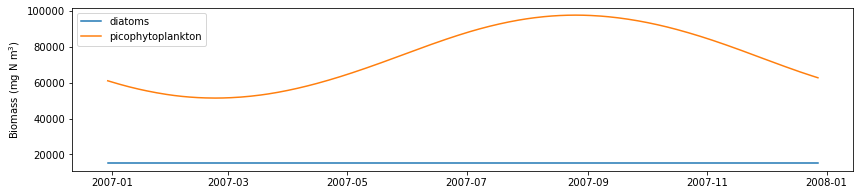

In [15]:
bio_group = groups.phytoplankton
location = strait_of_georgia
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'_N'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_ylabel('Biomass (mg N m$^3$)');

In [16]:
# Checking the same plots in terms of nitrogen
diatoms_SSAM_N = diatoms_SSAM_tb.sum(axis=1) #mg N
diatoms_SSC_N = diatoms_SSC_tz.sum(axis=1) * 14.006747 #mg N


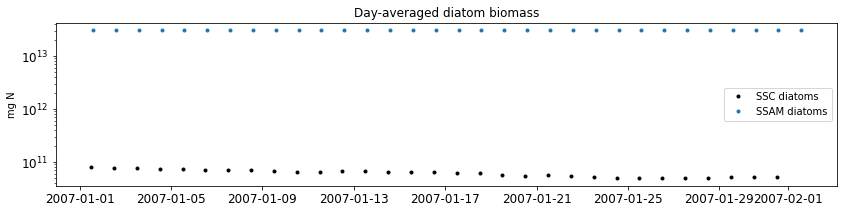

In [17]:
fig, ax = plt.subplots(figsize = (14,3)) 
ax.semilogy(ssc_data.time, diatoms_SSC_N, 'k.', linewidth = 2) #semilogy
ax.semilogy(ssam_time[5:37], diatoms_SSAM_N[5:37],'.', linewidth = 2)
ax.set_title('Day-averaged diatom biomass', fontsize = 12)
ax.set_ylabel('mg N')
ax.tick_params(labelsize=12)
ax.legend(('SSC diatoms', 'SSAM diatoms'), loc='best');

## Invertebrates

In [6]:
# Reading in Atlantis map

shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

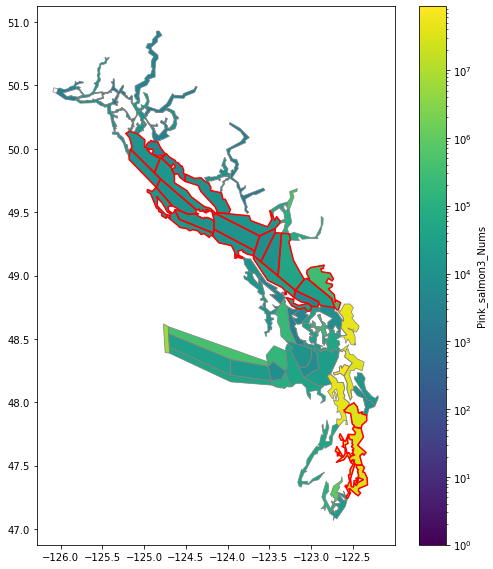

In [34]:
variable_name = 'Pink_salmon3_Nums'
plot_data = data.variables[variable_name]
plot_data = plot_data.sum(axis=0)
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[strait_of_georgia]
ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()), #vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');


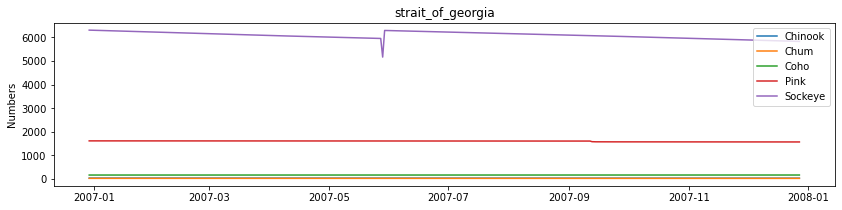

In [28]:
bio_group = groups.wild_salmon
location = strait_of_georgia
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('strait_of_georgia', fontsize = 12)
ax.set_ylabel('Numbers');

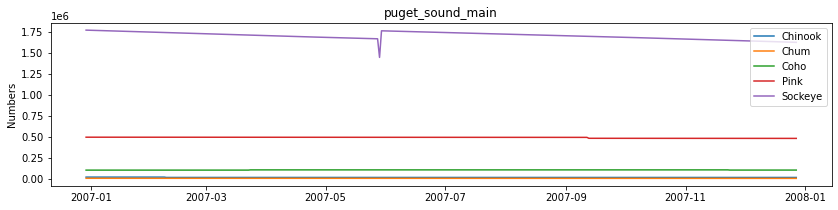

In [35]:
bio_group = groups.wild_salmon
location = puget_sound_main
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('puget_sound_main', fontsize = 12)
ax.set_ylabel('Numbers');

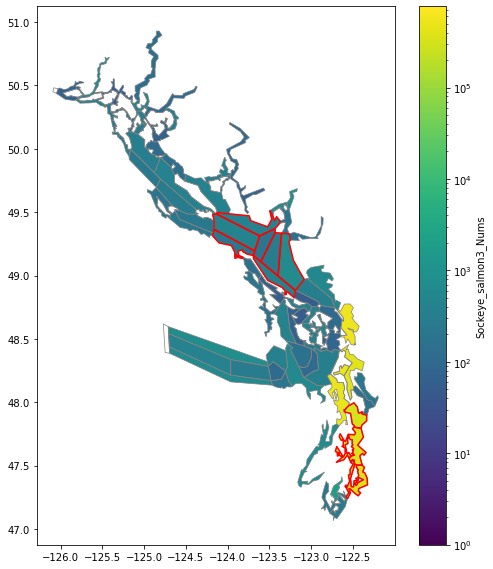

In [32]:
variable_name = 'Sockeye_salmon3_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[sog_center]
ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()),#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');


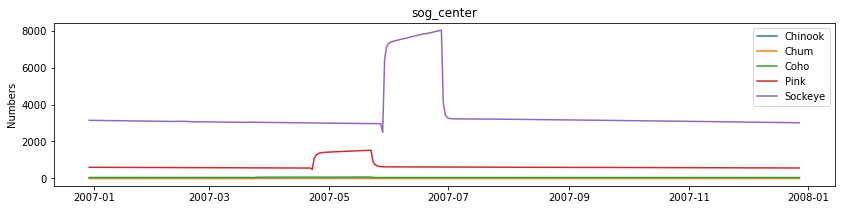

In [29]:
bio_group = groups.wild_salmon
location = sog_center
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'1_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('sog_center', fontsize = 12)
ax.set_ylabel('Numbers');

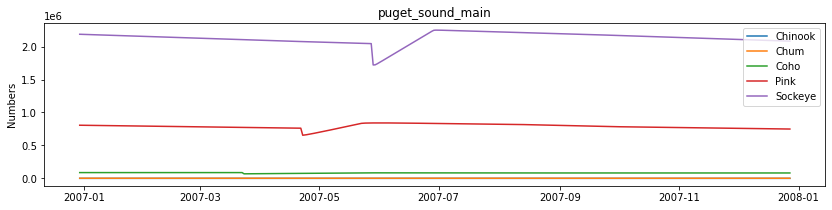

In [30]:
bio_group = groups.wild_salmon
location = puget_sound_main
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'1_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_title('puget_sound_main', fontsize = 12)
ax.set_ylabel('Numbers');

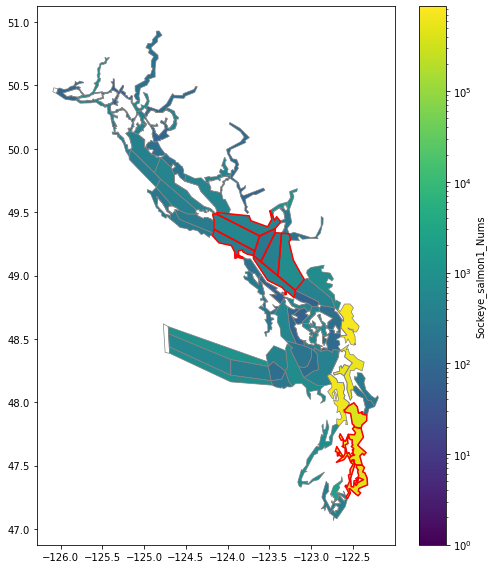

In [33]:
variable_name = 'Sockeye_salmon1_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[sog_center]
ps_df = data_df.loc[puget_sound_main]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,norm=colors.LogNorm(vmin=1, vmax=data_df.plot_data.max()),#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
ps_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');